# Importing library

In [ ]:
import argparse
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax,uint8
import os.path
from cv2.dnn import readNetFromDarknet,DNN_BACKEND_OPENCV,DNN_TARGET_CPU,NMSBoxes,blobFromImage
from cv2 import imwrite,rectangle,FILLED,putText,FONT_HERSHEY_SIMPLEX,getTextSize,VideoCapture,VideoWriter,VideoWriter_fourcc,CAP_PROP_FRAME_WIDTH,waitKey,getTickFrequency
import glob
from pathlib import Path

In [ ]:
import cv2
import numpy as np
import os

confThreshold = 0.3
nmsThreshold = 0.4
inpWidth, inpHeight = 416, 416

def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

def drawPred(classId, conf, left, top, right, bottom, frame):
    LP_extracted = frame[top+6:bottom-6, left+6:right-6]
    return LP_extracted

def postprocess(frame, outs):
    frameHeight, frameWidth = frame.shape[:2]
    classIds, confidences, boxes = [], [], []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x, center_y = int(detection[0] * frameWidth), int(detection[1] * frameHeight)
                width, height = int(detection[2] * frameWidth), int(detection[3] * frameHeight)
                left, top = int(center_x - width / 2), int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

    if len(indices) == 0:
        return None

    for i in indices.flatten():
        left, top, width, height = boxes[i]
        return drawPred(classIds[i], confidences[i], left, top, left + width, top + height, frame)

def LP_detection(image_path):
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"⚠️ Error: Could not read {image_path}")
        return None

    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))

    LP_extracted = postprocess(frame, outs)
    return LP_extracted

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    images = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    for img_name in images:
        img_path = os.path.join(input_folder, img_name)
        extracted_lp = LP_detection(img_path)

        if extracted_lp is not None:
            output_path = os.path.join(output_folder, img_name)
            cv2.imwrite(output_path, extracted_lp)
            print(f"✅ License plate saved: {output_path}")
        else:
            print(f"⚠️ No license plate detected in {img_name}")

# Load YOLO model
net = cv2.dnn.readNet("/content/drive/MyDrive/archive/lapi.weights", "/content/drive/MyDrive/archive/darknet-yolov3.cfg")

# Process a folder of images
input_folder = "/content/drive/MyDrive/test"
output_folder = "/content/gooddd"
process_folder(input_folder, output_folder)


✅ License plate saved: /content/gooddd/1002.jpg
✅ License plate saved: /content/gooddd/1001.jpg
✅ License plate saved: /content/gooddd/1000.jpg
✅ License plate saved: /content/gooddd/1009.jpg
✅ License plate saved: /content/gooddd/1008.jpg
✅ License plate saved: /content/gooddd/1013.jpg
✅ License plate saved: /content/gooddd/1012.jpg
✅ License plate saved: /content/gooddd/1010.jpg
✅ License plate saved: /content/gooddd/1007.jpg
✅ License plate saved: /content/gooddd/1005.jpg
✅ License plate saved: /content/gooddd/1004.jpg
✅ License plate saved: /content/gooddd/1011.jpg
✅ License plate saved: /content/gooddd/1006.jpg
✅ License plate saved: /content/gooddd/1003.jpg
✅ License plate saved: /content/gooddd/1014.jpg
✅ License plate saved: /content/gooddd/1026.jpg
✅ License plate saved: /content/gooddd/1027.jpg
✅ License plate saved: /content/gooddd/1019.jpg
✅ License plate saved: /content/gooddd/1018.jpg
✅ License plate saved: /content/gooddd/1025.jpg
✅ License plate saved: /content/gooddd/1

In [ ]:
'''def histogram_of_pixel_projection(img):
    """

    This method is responsible for licence plate segmentation with histogram of pixel projection approach

    :param: input image

    :return: list of image, each one contain a digit or the word "تونس"

    """
    # list that will contains all digits
    caracrter_list_image = list()

    # img = crop(img)

    # Add black border to the image
    BLACK = [0, 0, 0]
    img = cv2.copyMakeBorder(img, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=BLACK)

    # change to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Change to numpy array format
    nb = np.array(gray)

    # Binarization
    nb[nb > 120] = 255
    nb[nb < 120] = 0

    # compute the sommation
    x_sum = cv2.reduce(nb, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    y_sum = cv2.reduce(nb, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)

    # rotate the vector x_sum
    x_sum = x_sum.transpose()

    # get height and weight
    x = gray.shape[1]
    y = gray.shape[0]

    # division the result by height and weight
    x_sum = x_sum / y
    y_sum = y_sum / x

    # x_arr and y_arr are two vector weight and height to plot histogram projection properly
    x_arr = np.arange(x)
    y_arr = np.arange(y)

    # convert x_sum to numpy array
    z = np.array(x_sum)

    # convert y_arr to numpy array
    w = np.array(y_sum)

    # convert to zero small details
    z[z < 15] = 0
    z[z > 15] = 1

    # convert to zero small details and 1 for needed details
    w[w < 20] = 0
    w[w > 20] = 1

    # vertical segmentation
    test = z.transpose() * nb

    # horizontal segmentation
    test = w * test

    # plot histogram projection result using pyplot
    horizontal = plt.plot(w, y_arr)
    #plt.show()
    vertical = plt.plot(x_arr ,z)
    #plt.show()
    #plt.show(horizontal)
    #plt.show(vertical)

    f = 0
    ff = z[0]
    t1 = list()
    t2 = list()
    for i in range(z.size):
        if z[i] != ff:
            f += 1
            ff = z[i]
            t1.append(i)
    rect_h = np.array(t1)

    f = 0
    ff = w[0]
    for i in range(w.size):
        if w[i] != ff:
            f += 1
            ff = w[i]
            t2.append(i)
    rect_v = np.array(t2)

    # take the appropriate height
    rectv = []
    rectv.append(rect_v[0])
    rectv.append(rect_v[1])
    max = int(rect_v[1]) - int(rect_v[0])
    for i in range(len(rect_v) - 1):
        diff2 = int(rect_v[i + 1]) - int(rect_v[i])

        if diff2 > max:
            rectv[0] = rect_v[i]
            rectv[1] = rect_v[i + 1]
            max = diff2

    # extract caracter
    for i in range(len(rect_h) - 1):

        # eliminate slice that can't be a digit, a digit must have width bigger then 8
        diff1 = int(rect_h[i + 1]) - int(rect_h[i])

        if (diff1 > 5) and (z[rect_h[i]] == 1):
            # cutting nb (image) and adding each slice to the list caracrter_list_image
            caracrter_list_image.append(nb[int(rectv[0]):int(rectv[1]), rect_h[i]:rect_h[i + 1]])

            # draw rectangle on digits
            cv2.rectangle(img, (rect_h[i], rectv[0]), (rect_h[i + 1], rectv[1]), (0, 255, 0), 1)

    # Show segmentation result
    image = plt.imshow(img)
    plt.show()
    #plt.show(image)

    return caracrter_list_image'''

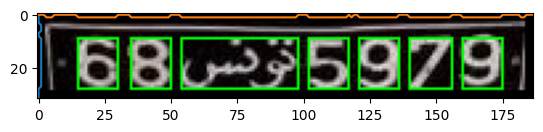

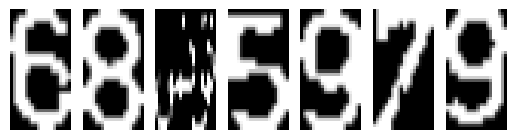

In [ ]:
'''Tunisian_LP1 =  cv2.imread("/content/testt/6.jpg")
char_TN_LP1 = histogram_of_pixel_projection(Tunisian_LP1)

for i in range(len(char_TN_LP1)):
    plt.subplot(1, len(char_TN_LP1), i+1)
    a=cv2.resize(char_TN_LP1[i],(20,40))
    plt.imshow(a, cmap='gray')
    plt.axis('off')'''

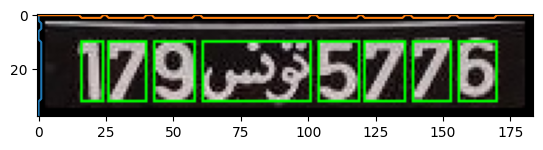

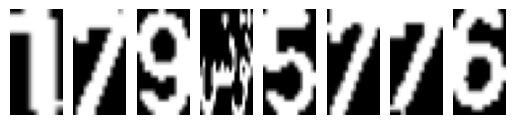

In [ ]:
'''Tunisian_LP1 =  cv2.imread("/content/testt/21.jpg")
char_TN_LP1 = histogram_of_pixel_projection(Tunisian_LP1)

for i in range(len(char_TN_LP1)):
    plt.subplot(1, len(char_TN_LP1), i+1)
    a=cv2.resize(char_TN_LP1[i],(20,40))
    plt.imshow(a, cmap='gray')
    plt.axis('off')'''

In [ ]:
from tensorflow.keras.models import load_model
from numpy import array, ones, zeros, arange, uint8
from cv2 import reduce,copyMakeBorder,BORDER_CONSTANT,CV_32S,REDUCE_SUM,COLOR_BGR2GRAY,cvtColor,rectangle,resize,addWeighted,putText,FONT_HERSHEY_DUPLEX,FONT_HERSHEY_SIMPLEX


# modeeel

In [ ]:
model = load_model('/content/drive/MyDrive/archive/ocrmodel.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Testing on a single image

In [ ]:
def histogram_of_pixel_projection(img):
    """

    This method is responsible for licence plate segmentation with histogram of pixel projection approach

    :param: input image

    :return: list of image, each one contain a digit or the word "تونس"

    """
    # list that will contains all digits
    caracrter_list_image = list()

    # img = crop(img)

    # Add black border to the image
    BLACK = [0, 0, 0]
    img = cv2.copyMakeBorder(img, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=BLACK)

    # change to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Change to numpy array format
    nb = np.array(gray)

    # Binarization
    nb[nb > 120] = 255
    nb[nb < 120] = 0

    # compute the sommation
    x_sum = cv2.reduce(nb, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    y_sum = cv2.reduce(nb, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)

    # rotate the vector x_sum
    x_sum = x_sum.transpose()

    # get height and weight
    x = gray.shape[1]
    y = gray.shape[0]

    # division the result by height and weight
    x_sum = x_sum / y
    y_sum = y_sum / x

    # x_arr and y_arr are two vector weight and height to plot histogram projection properly
    x_arr = np.arange(x)
    y_arr = np.arange(y)

    # convert x_sum to numpy array
    z = np.array(x_sum)

    # convert y_arr to numpy array
    w = np.array(y_sum)

    # convert to zero small details
    z[z < 15] = 0
    z[z > 15] = 1

    # convert to zero small details and 1 for needed details
    w[w < 20] = 0
    w[w > 20] = 1

    # vertical segmentation
    test = z.transpose() * nb

    # horizontal segmentation
    test = w * test

    # plot histogram projection result using pyplot
    horizontal = plt.plot(w, y_arr)
    #plt.show()
    vertical = plt.plot(x_arr ,z)
    #plt.show()
    #plt.show(horizontal)
    #plt.show(vertical)

    f = 0
    ff = z[0]
    t1 = list()
    t2 = list()
    for i in range(z.size):
        if z[i] != ff:
            f += 1
            ff = z[i]
            t1.append(i)
    rect_h = np.array(t1)

    f = 0
    ff = w[0]
    for i in range(w.size):
        if w[i] != ff:
            f += 1
            ff = w[i]
            t2.append(i)
    rect_v = np.array(t2)

    # take the appropriate height
    rectv = []
    rectv.append(rect_v[0])
    rectv.append(rect_v[1])
    max = int(rect_v[1]) - int(rect_v[0])
    for i in range(len(rect_v) - 1):
        diff2 = int(rect_v[i + 1]) - int(rect_v[i])

        if diff2 > max:
            rectv[0] = rect_v[i]
            rectv[1] = rect_v[i + 1]
            max = diff2

    # extract caracter
    for i in range(len(rect_h) - 1):

        # eliminate slice that can't be a digit, a digit must have width bigger then 8
        diff1 = int(rect_h[i + 1]) - int(rect_h[i])

        if (diff1 > 5) and (z[rect_h[i]] == 1):
            # cutting nb (image) and adding each slice to the list caracrter_list_image
            caracrter_list_image.append(nb[int(rectv[0]):int(rectv[1]), rect_h[i]:rect_h[i + 1]])

            # draw rectangle on digits
            cv2.rectangle(img, (rect_h[i], rectv[0]), (rect_h[i + 1], rectv[1]), (0, 255, 0), 1)

    # Show segmentation result
    image = plt.imshow(img)
    plt.show()
    #plt.show(image)

    return caracrter_list_image

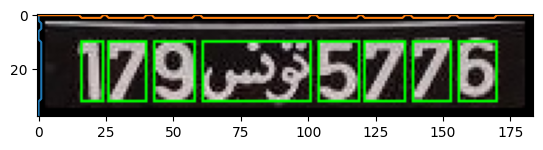

In [ ]:
Tunisian_LP =  cv2.imread("/content/lp/21.jpg")
char_TN_LP = histogram_of_pixel_projection(Tunisian_LP)

In [ ]:
import numpy as np
import cv2

def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char, model):
    dic = {}
    characters = '0123456789T'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # Iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # Preparing image for the model

        y_probs = model.predict(img)  # Get predictions
        y_ = np.argmax(y_probs, axis=1)[0]  # Get the class index

        character = dic[y_]
        if character == "T":
            output.append("Tunisie")
        else:
            output.append(character)  # Storing the result in a list

    plate_number = ''.join(output)
    return output




# Got ['1', '7', '9', 'Tunisie', '5', '7', '7', '6']

In [ ]:
app=[]
for i, ch in enumerate(char_TN_LP):

    predicted_char = show_results(char_TN_LP, model)[i]  # Pass `model` as an argument
   # print(f"{ predicted_char}")
    app.append(predicted_char)

print(app)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

<Figure size 1000x600 with 0 Axes>

# for whole folder

In [ ]:
def histogram_of_pixel_projection(img):
    """
    This method is responsible for license plate segmentation using the histogram of pixel projection approach.

    :param: input image
    :return: list of images, each one containing a digit or the word "تونس"
    """
    # list that will contain all digits
    caracrter_list_image = list()

    # Add black border to the image
    BLACK = [0, 0, 0]
    img = cv2.copyMakeBorder(img, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=BLACK)

    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert to numpy array
    nb = np.array(gray)

    # Binarization
    nb[nb > 120] = 255
    nb[nb < 120] = 0

    # Compute summation
    x_sum = cv2.reduce(nb, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    y_sum = cv2.reduce(nb, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)

    # Rotate the vector x_sum
    x_sum = x_sum.transpose()

    # Get height and width
    x = gray.shape[1]
    y = gray.shape[0]

    # Divide by height and width for scaling
    x_sum = x_sum / y
    y_sum = y_sum / x

    # x_arr and y_arr are vectors for plotting the histogram projection
    x_arr = np.arange(x)
    y_arr = np.arange(y)

    # Convert x_sum to numpy array
    z = np.array(x_sum)

    # Convert y_sum to numpy array
    w = np.array(y_sum)

    # Convert small details to 0
    z[z < 15] = 0
    z[z > 15] = 1

    # Convert to zero small details and 1 for needed details
    w[w < 10] = 0  # You can adjust this threshold
    w[w >= 10] = 1

    # Vertical segmentation
    test = z.transpose() * nb

    # Horizontal segmentation
    test = w * test

    # Debugging: print projections
    # plt.plot(w, y_arr)
    # plt.plot(x_arr, z)

    f = 0
    ff = z[0]
    t1 = list()
    t2 = list()
    for i in range(z.size):
        if z[i] != ff:
            f += 1
            ff = z[i]
            t1.append(i)
    rect_h = np.array(t1)

    f = 0
    ff = w[0]
    for i in range(w.size):
        if w[i] != ff:
            f += 1
            ff = w[i]
            t2.append(i)
    rect_v = np.array(t2)

    # Check if rect_v is empty
    if len(rect_v) < 2:
        print("No plate detected")
        return []  # Return an empty list if no license plate is detected

    # Take the appropriate height
    rectv = [rect_v[0], rect_v[1]]
    max_height = int(rect_v[1]) - int(rect_v[0])

    for i in range(len(rect_v) - 1):
        diff2 = int(rect_v[i + 1]) - int(rect_v[i])
        if diff2 > max_height:
            rectv[0] = rect_v[i]
            rectv[1] = rect_v[i + 1]
            max_height = diff2

    # Extract characters
    for i in range(len(rect_h) - 1):
        diff1 = int(rect_h[i + 1]) - int(rect_h[i])

        if diff1 > 5 and z[rect_h[i]] == 1:
            # Cutting the image and adding each slice to the list
            caracrter_list_image.append(nb[int(rectv[0]):int(rectv[1]), rect_h[i]:rect_h[i + 1]])

            # Optionally draw rectangle on digits
            cv2.rectangle(img, (rect_h[i], rectv[0]), (rect_h[i + 1], rectv[1]), (0, 255, 0), 1)

    # Show segmentation result
    # image = plt.imshow(img)
    # plt.show()

    return caracrter_list_image


In [ ]:
import numpy as np
import cv2

def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char, model):
    dic = {}
    characters = '0123456789T'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # Iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # Preparing image for the model

        y_probs = model.predict(img)  # Get predictions
        y_ = np.argmax(y_probs, axis=1)[0]  # Get the class index

        character = dic[y_]
        if character == "T":
            output.append("Tunisie")
        else:
            output.append(character)  # Storing the result in a list

    plate_number = ''.join(output)
    return output




In [ ]:
image_folder = "/content/gooddd/"

# List of all images in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Initialize an empty list to store the results
full = []

# Process each image in the folder
for image_file in image_files:
    img_path = os.path.join(image_folder, image_file)
    Tunisian_LP = cv2.imread(img_path)

    # Get the segmented characters from the license plate
    char_TN_LP = histogram_of_pixel_projection(Tunisian_LP)

    # Skip if no license plate was detected (empty list returned)
    if not char_TN_LP:
        print(f"No plate detected in {image_file}, moving to next.")
        continue

    # Initialize a list to store predicted characters for the current image
    app = []

    # Predict characters for each segmented part
    for i, ch in enumerate(char_TN_LP):
        predicted_char = show_results(char_TN_LP, model)[i]  # Pass model as an argument
        app.append(predicted_char)

    # Append the list of predicted characters for the current image to the full list
    full.append(app)

    # Print the predicted characters for this image
    print(f"Predictions for {image_file}: {app}")

# If you want to see all results after processing all images, you can print full
print("All predictions:")
print(full)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

In [ ]:
import pandas as pd

# Convert list of lists (full) into a DataFrame with image filenames
df = pd.DataFrame(full)

# Add the 'img_id' column to track which image each row corresponds to
df.insert(0, "img_id", image_files)  # Insert 'img_id' at the first position

# Rename columns dynamically to Char_1, Char_2, ..., Char_N
df.columns = ["img_id"] + [f"Char_{i+1}" for i in range(df.shape[1] - 1)]

# Replace 'Tunisie' with 'T' in the entire DataFrame
df.replace("Tunisie", "T", inplace=True)

# Display the DataFrame
print(df)


In [ ]:
a=df.to_csv('sample.csv', index=False)